Importing the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np
import plotly.express as px
import warnings
import statsmodels.api as sm

Loading the Dataset

In [ ]:
from google.colab import files

# Upload the file manually
uploaded = files.upload()

# Load the dataset
import pandas as pd
data = pd.read_csv(list(uploaded.keys())[0])

Saving Tax_District_Property_Valuation_Data.csv to Tax_District_Property_Valuation_Data.csv


<ipython-input-2-2b6445f0afb2>:8: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(list(uploaded.keys())[0])


In [ ]:
print(data.head())
print(data.info())  # Check for data types and missing values

   Valuation Year  County Number County  Tax District Number  \
0            2013              1  ADAIR                    1   
1            2013              1  ADAIR                    2   
2            2013              1  ADAIR                    3   
3            2013              1  ADAIR                    4   
4            2013              1  ADAIR                    5   

  Valuation Property Type                                  Tax District Name  \
0                   Rural                     UNION TWP/ORIENT MACKSBURG SCH   
1                   Rural                    ORIENT TWP/ORIENT MACKSBURG SCH   
2                   Rural  RICHLAND TWP/ORIENT MACKSBURG SCH/GREENFIELD FIRE   
3                   Rural                       LEE TWP/ORIENT MACKSBURG SCH   
4                   Urban                   ORIENT CITY/ORIENT MACKSBURG SCH   

   TIF Flag TIF Type  City Ag Land  City Exempt  ...  Assessed Open Space  \
0     False  Non-TIF         False        False  ...     

Check for missing values in the dataset

In [ ]:
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Valuation Year                              0
County Number                               0
County                                      0
Tax District Number                         0
Valuation Property Type                     0
Tax District Name                           0
TIF Flag                                    0
TIF Type                                    0
City Ag Land                                0
City Exempt                                 0
Schools Only                                0
Homestead                                   0
Consolidated Tax Rate                       0
Taxable Residential                         0
Taxable Ag Land                             0
Taxable Ag Building                         0
Taxable Commercial                          0
Taxable Industrial                          0
Taxable Industrial M&E                      0
Taxable Other Personal Real Estate          0
Taxable Railroads                           0
Taxable Utilities

Data Assumptions

Homoscedasticity (Constant Variance of Errors)

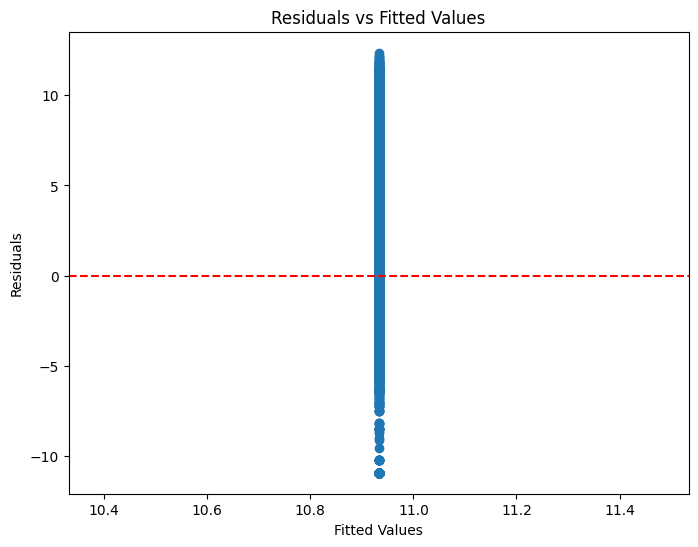

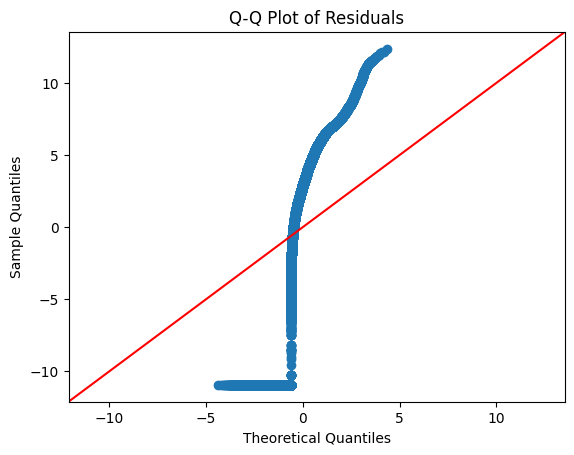

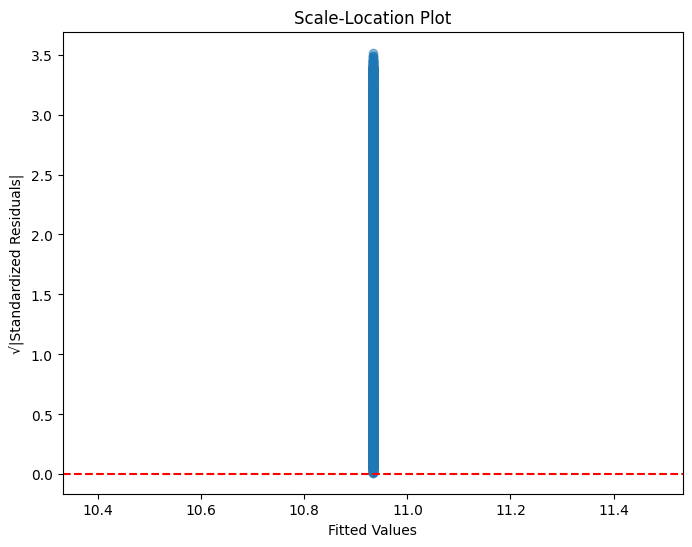

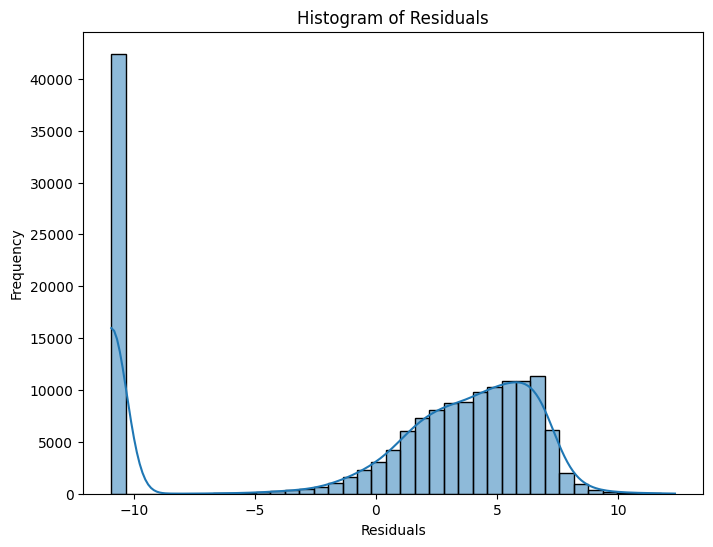

                            OLS Regression Results                            
Dep. Variable:           Assessed Net   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 07 Nov 2024   Prob (F-statistic):                nan
Time:                        20:59:55   Log-Likelihood:            -5.3262e+05
No. Observations:              158687   AIC:                         1.065e+06
Df Residuals:                  158686   BIC:                         1.065e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Valuation Year     0.0055   8.85e-06    627.

In [ ]:
# Convert the 'Valuation Year' column to datetime and extract the year
data['Valuation Year'] = pd.to_datetime(data['Valuation Year'], errors='coerce').dt.year

# Log transform the target variable to handle skewness (optional, based on data distribution)
data['Assessed Net'] = np.log1p(data['Assessed Net'])  # log(1 + x) transformation

# Define the predictor and response variables
X = sm.add_constant(data['Valuation Year'])  # Add a constant term
y = data['Assessed Net']

# Fit the linear regression model
model = sm.OLS(y, X).fit()
data['fitted'] = model.fittedvalues
data['residuals'] = model.resid

# Plot Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(data['fitted'], data['residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Additional Diagnostic Plots

# 1. Q-Q Plot to check for normality of residuals
sm.qqplot(data['residuals'], line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 2. Scale-Location Plot (Standardized Residuals vs Fitted Values)
plt.figure(figsize=(8, 6))
plt.scatter(data['fitted'], np.sqrt(np.abs(data['residuals'])), alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Scale-Location Plot')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.show()

# 3. Histogram of residuals to check distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Summary of the model
print(model.summary())

Linearity

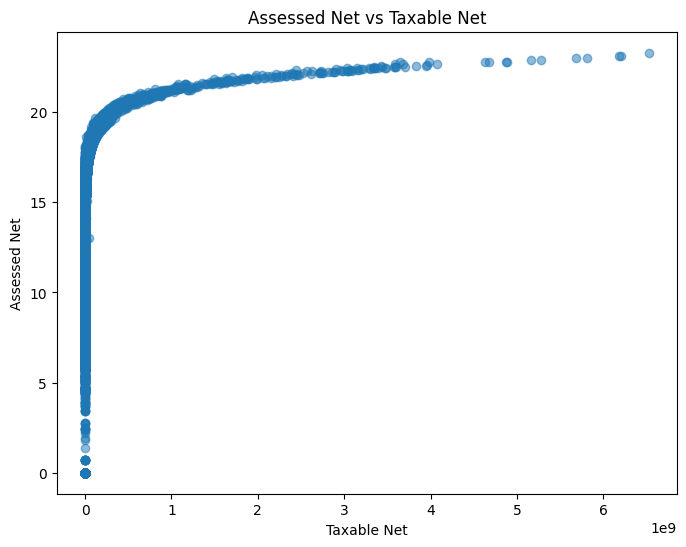

In [ ]:
# Scatter plot to check linearity
plt.figure(figsize=(8, 6))
plt.scatter(data['Taxable Net'], data['Assessed Net'], alpha=0.5)
plt.plot(data['Valuation Year'], model.fittedvalues, color='red')
plt.title('Assessed Net vs Taxable Net')
plt.xlabel('Taxable Net')
plt.ylabel('Assessed Net')
plt.show()


Normally Distributed Residuals

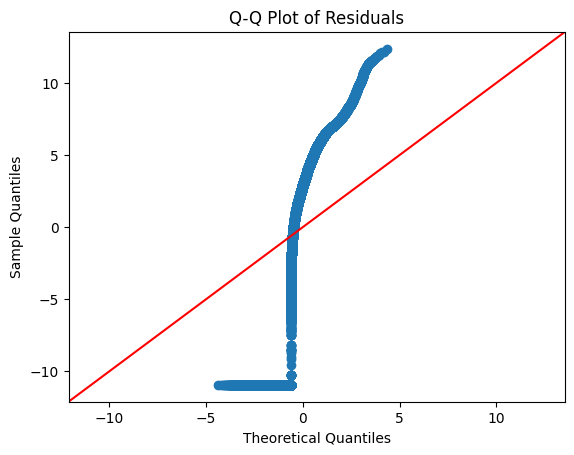

Shapiro-Wilk test p-value: 1.7172141206597325e-145


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 158687.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# Q-Q plot for normality of residuals
sm.qqplot(data['residuals'], line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test for normality
from scipy.stats import shapiro

stat, p_value = shapiro(data['residuals'])
print(f'Shapiro-Wilk test p-value: {p_value}')

Correlation

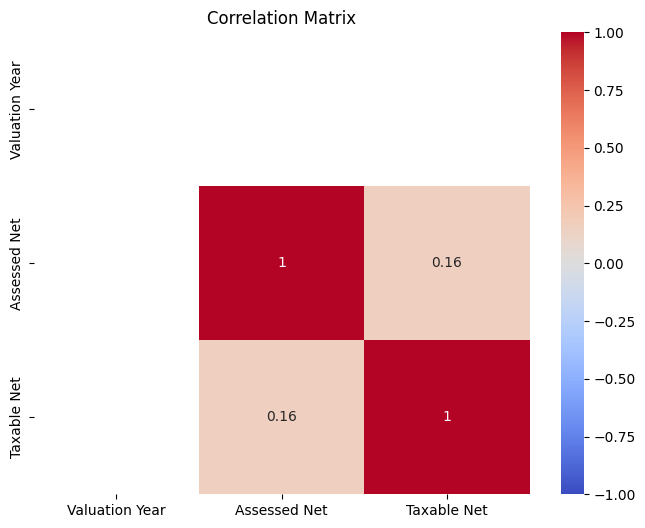

In [ ]:
# Correlation matrix
correlation_matrix = data[['Valuation Year', 'Assessed Net', 'Taxable Net']].corr()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Filter data to the last decade if available
min_year = data['Valuation Year'].min()
max_year = data['Valuation Year'].max()
if max_year - min_year >= 10:
    data_last_decade = data[data['Valuation Year'] >= max_year - 9]
else:
    data_last_decade = data  # Use all data if less than a decade is available

# Group by Valuation Year, County, and Tax District for total assessed valuations
valuation_by_county_district = data_last_decade.groupby(['Valuation Year', 'County', 'Tax District Number']).agg({
    'Assessed Net': 'sum'
}).reset_index()

In [ ]:
# Calculate variance of assessed values for each county
county_variance = valuation_by_county_district.groupby('County')['Assessed Net'].var().sort_values(ascending=False)
top_counties = county_variance.head(3).index  # Select the top 3 counties with the highest variance

In [ ]:
# Create a new dataframe to store only the top 3 counties and their 3 districts with highest variance
top_county_districts = pd.DataFrame()
for county in top_counties:
    # Filter data for each top county
    county_data = valuation_by_county_district[valuation_by_county_district['County'] == county]
    # Calculate variance for each district within the county
    district_variance = county_data.groupby('Tax District Number')['Assessed Net'].var().sort_values(ascending=False)
    # Select the top 3 districts with the highest variance
    top_districts = district_variance.head(3).index
    # Filter the original data to keep only these top districts
    top_county_districts = pd.concat([top_county_districts, county_data[county_data['Tax District Number'].isin(top_districts)]])

In [ ]:
# Plot using Plotly for interactivity
fig = px.line(top_county_districts, x='Valuation Year', y='Assessed Net', color='County',
              line_group='Tax District Number', hover_name='Tax District Number',
              labels={'Assessed Net': 'Assessed Property Valuation', 'Valuation Year': 'Year'},
              title='Evolution of Assessed Property Valuations for Top Counties and Districts')

# Customize layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Total Assessed Valuation",
    legend_title="County",
    hovermode="x unified"
)

fig.show()

In [ ]:
# Group by Valuation Year, County, and Property Type to get total valuations per type and county
valuation_growth = data.groupby(['Valuation Year', 'County', 'Valuation Property Type']).agg({
    'Assessed Net': 'sum',
    'Taxable Net': 'sum'
}).sort_index().reset_index()

In [ ]:
# Calculate year-over-year growth rates within each group
valuation_growth['Assessed Growth Rate'] = valuation_growth.groupby(['County', 'Valuation Property Type'])['Assessed Net'].pct_change() * 100
valuation_growth['Taxable Growth Rate'] = valuation_growth.groupby(['County', 'Valuation Property Type'])['Taxable Net'].pct_change() * 100

In [ ]:
# Drop NA values created by pct_change
valuation_growth = valuation_growth.dropna(subset=['Assessed Growth Rate', 'Taxable Growth Rate'])

In [ ]:
# Average growth rate for each property type
average_growth_by_type = valuation_growth.groupby('Valuation Property Type').agg({
    'Assessed Growth Rate': 'mean',
    'Taxable Growth Rate': 'mean'
}).reset_index()

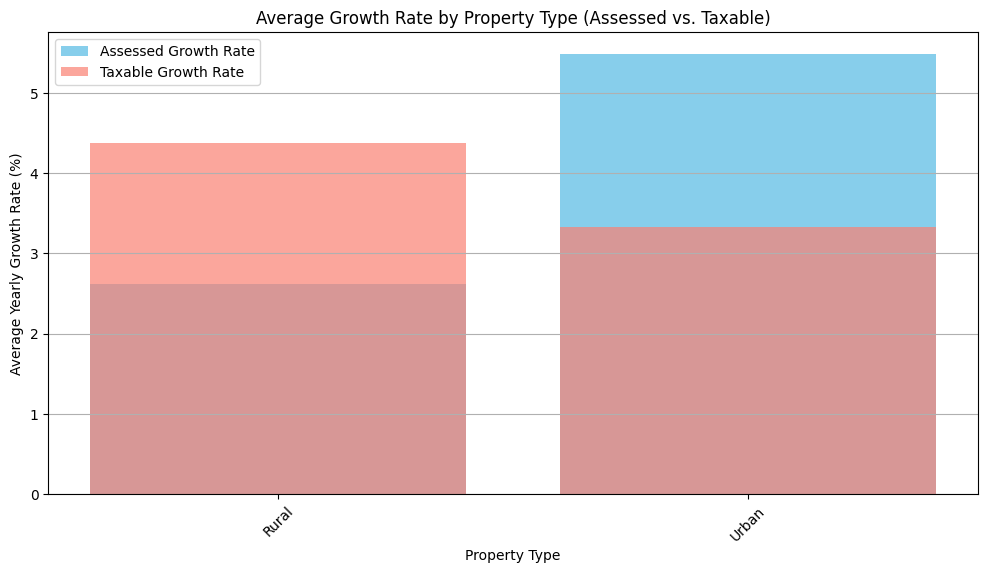

In [ ]:
# Plot the average growth rate by property type
plt.figure(figsize=(12, 6))
plt.bar(average_growth_by_type['Valuation Property Type'], average_growth_by_type['Assessed Growth Rate'], color='skyblue', label='Assessed Growth Rate')
plt.bar(average_growth_by_type['Valuation Property Type'], average_growth_by_type['Taxable Growth Rate'], color='salmon', label='Taxable Growth Rate', alpha=0.7)
plt.title("Average Growth Rate by Property Type (Assessed vs. Taxable)")
plt.xlabel("Property Type")
plt.ylabel("Average Yearly Growth Rate (%)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# Aggregate Assessed Net values by year
valuation_by_year = data.groupby('Valuation Year').agg({'Assessed Net': 'sum'}).reset_index()
ts_data = valuation_by_year.set_index('Valuation Year')['Assessed Net']

In [ ]:
# Split data into training and test sets (80-20 split)
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

In [ ]:
# Fit an ARIMA model on the training data
model = ARIMA(train, order=(1, 1, 1))  # ARIMA(p, d, q) order can be tuned based on data
fitted_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

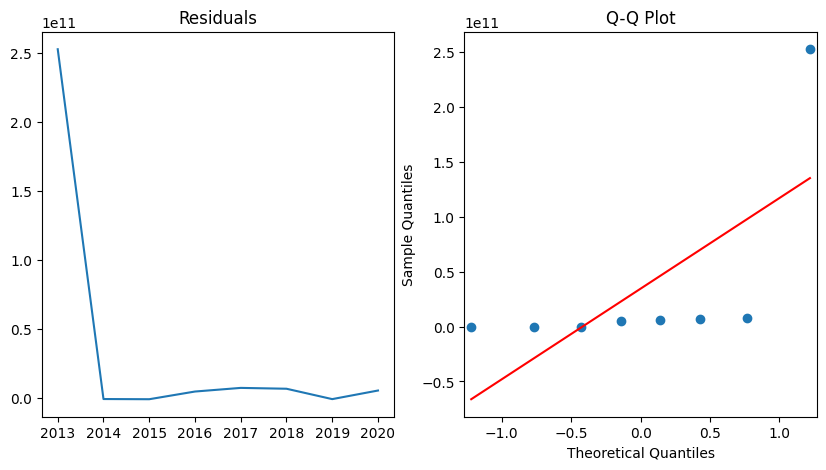

In [ ]:
import statsmodels.api as sm
# Plot the residuals
residuals = fitted_model.resid
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(122)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot')
plt.show()

In [ ]:
# Forecast future values (test set + additional forecast for visualization)
forecast_steps = len(test) + 5  # Forecast beyond the test set for additional future predictions
forecast = fitted_model.forecast(steps=forecast_steps)
# Suppress warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



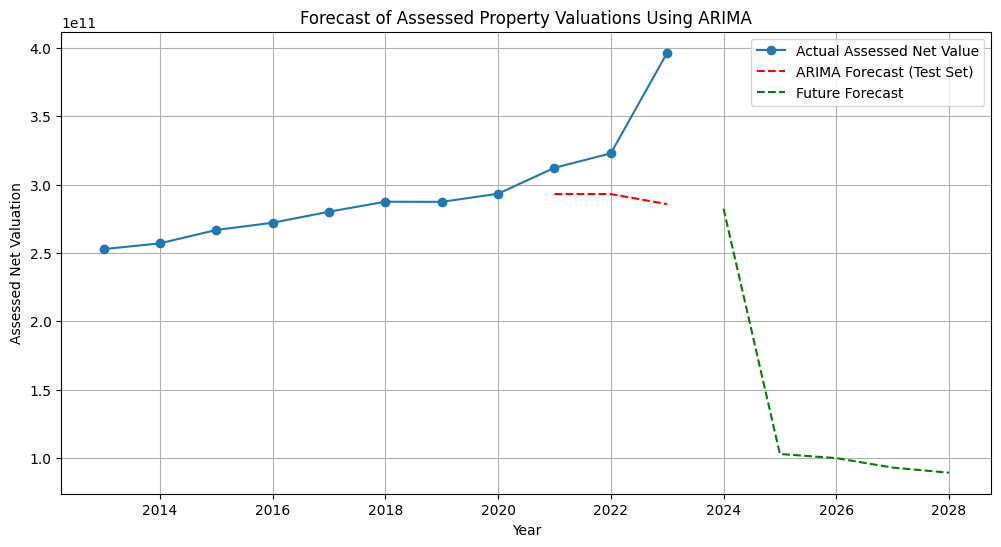

In [ ]:
# Plot the forecasted results
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data, label="Actual Assessed Net Value", marker='o')
plt.plot(test.index, forecast[:len(test)], label="ARIMA Forecast (Test Set)", linestyle='--', color='red')
plt.plot(range(test.index[-1]+1, test.index[-1]+6), forecast[len(test):], label="Future Forecast", linestyle='--', color='green')
plt.title("Forecast of Assessed Property Valuations Using ARIMA")
plt.xlabel("Year")
plt.ylabel("Assessed Net Valuation")
plt.legend()
plt.grid()
plt.show()
# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# Evaluate forecast on the test set
test_forecast = forecast[:len(test)]  # Limit forecast to match test set length

# Calculate error metrics
mae = mean_absolute_error(test, test_forecast)
mape = mean_absolute_percentage_error(test, test_forecast) * 100  # convert to percentage
rmse = np.sqrt(mean_squared_error(test, test_forecast))

# Calculate accuracy
accuracy = 100 - mape

# Print model evaluation metrics and accuracy
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Model Accuracy: {accuracy:.2f}%")

# Additional model parameters
print("\nModel Parameters:")
print(fitted_model.summary())
# Suppress warnings
warnings.filterwarnings("ignore")

Mean Absolute Error (MAE): 53213822308.62319
Mean Absolute Percentage Error (MAPE): 14.43%
Root Mean Square Error (RMSE): 67108265782.014206
Model Accuracy: 85.57%

Model Parameters:
                                      SARIMAX Results                                       
Dep. Variable:                         Assessed Net   No. Observations:                    8
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -166.014
Date:                              Fri, 01 Nov 2024   AIC                            342.028
Time:                                      19:30:07   BIC                            341.757
Sample:                                           0   HQIC                           338.685
                                                - 8                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings
warnings.filterwarnings("ignore")

# Define ARIMA and seasonal order
order = (1, 1, 1)  # Replace with optimized values if available
seasonal_order = (1, 1, 1, 12)  # Adjust `s` if seasonality period is different

# Fit SARIMA model on the training data
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit()

# Forecast for the length of the test set
test_forecast = fitted_model.forecast(steps=len(test))


In [ ]:
# Calculate error metrics
mae = mean_absolute_error(test, test_forecast)
mape = mean_absolute_percentage_error(test, test_forecast) * 100  # convert to percentage
rmse = np.sqrt(mean_squared_error(test, test_forecast))
accuracy = 100 - mape

# Print model summary and evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Model Accuracy: {accuracy:.2f}%\n")

print("SARIMA Model Summary:")
print(fitted_model.summary())

Mean Absolute Error (MAE): 50533121407.666664
Mean Absolute Percentage Error (MAPE): 13.74%
Root Mean Square Error (RMSE): 62881131890.481026
Model Accuracy: 86.26%

SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                       Assessed Net   No. Observations:                    8
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Fri, 01 Nov 2024   AIC                             10.000
Time:                                    19:12:45   BIC                                nan
Sample:                                         0   HQIC                               nan
                                              - 8                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



In [ ]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to evaluate ARIMA models
def evaluate_arima_model(train, p, d, q):
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    return model_fit.aic  # Return the AIC value

# Grid search for p, d, q values
def grid_search_arima(train, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            aic = evaluate_arima_model(train, p, d, q)
            print(f'ARIMA({p},{d},{q}) AIC: {aic}')
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue  # Handle any errors during model fitting

    return best_order

# Define the range of p, d, q values to consider
p_values = range(0, 3)  # Adjust range as needed
d_values = range(0, 2)  # Usually 0 or 1
q_values = range(0, 3)  # Adjust range as needed

# Run grid search
best_order = grid_search_arima(train, p_values, d_values, q_values)
print(f'Best ARIMA Order: {best_order}')


ARIMA(0,0,0) AIC: 410.09588349743046
ARIMA(0,0,1) AIC: 398.43261202681754
ARIMA(0,0,2) AIC: 400.012551665469
ARIMA(0,1,0) AIC: 4031.6727081437466
ARIMA(0,1,1) AIC: 340.25892878793917
ARIMA(0,1,2) AIC: 344.01125718518693
ARIMA(1,0,0) AIC: 392.2281602407827
ARIMA(1,0,1) AIC: 391.66625172974193
ARIMA(1,0,2) AIC: 401.41589354544533
ARIMA(1,1,0) AIC: 340.8493389945953
ARIMA(1,1,1) AIC: 331.0295458824866
ARIMA(1,1,2) AIC: 330.6146406951214
ARIMA(2,0,0) AIC: 389.44552102653034
ARIMA(2,0,1) AIC: 387.7780400213132
ARIMA(2,0,2) AIC: 403.09232626430924
ARIMA(2,1,0) AIC: 341.18009550249866
ARIMA(2,1,1) AIC: 330.28164163404847
ARIMA(2,1,2) AIC: 332.21927989134264
Best ARIMA Order: (2, 1, 1)


In [ ]:
best_p, best_d, best_q = best_order
# Fit the ARIMA model using the best parameters
model = ARIMA(train, order=(best_p, best_d, best_q))
fitted_model = model.fit()

Model Parameters:
                               SARIMAX Results                                
Dep. Variable:           Assessed Net   No. Observations:                    8
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -161.141
Date:                Fri, 01 Nov 2024   AIC                            330.282
Time:                        19:34:50   BIC                            330.065
Sample:                             0   HQIC                           327.607
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8104      0.290      2.799      0.005       0.243       1.378
ar.L2          0.0228      0.215      0.106      0.916      -0.399       0.445
ma.L1         -0.7974      0.156  

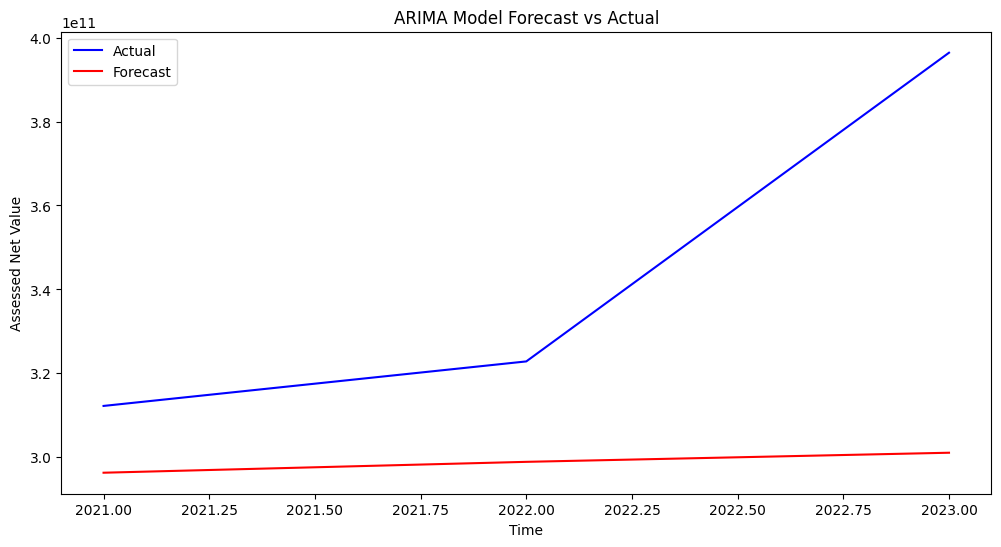

In [ ]:
# Display model parameters
print("Model Parameters:")
print(fitted_model.summary())

# Make predictions on the test set
forecast = fitted_model.forecast(steps=len(test))

# Calculate accuracy metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
accuracy = 100 - mape

print(f'\nModel Accuracy:{accuracy:.2f}%\n')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Optionally, visualize the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Assessed Net Value')
plt.legend()
plt.show()